# Inverse Distance Verification: Cressman and Barnes

Two popular interpolation schemes that use inverse distance weighting of observations are the Barnes and Cressman analyses. The Cressman analysis is relatively straightforward and uses the ratio between distance of an observation from a grid cell and the maximum allowable distance to calculate the relative importance of an observation for calculating an interpolation value.  Barnes uses the inverse exponential ratio of each distance between an observation and a grid cell and the average spacing of the observations over the domain.
   
Algorithmically:

1) A KDTree data structure is built using the locations of each observation.

2) All observations within a maximum allowable distance of a particular grid cell are found in O(log n) time.

3) Using the weighting rules for cressman or barnes analyses, the observations are given a proportional value, primarily based on their distance from the grid cell.

4) The sum of these proportional values is calculated and this value is used as the interpolated value.

5) Steps 2 through 4 are repeated for each grid cell.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist

from metpy.gridding import points
from metpy.gridding.gridding_functions import calc_kappa
from metpy.gridding.interpolation import cressman_point, barnes_point
from metpy.gridding.triangles import dist_2

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

def draw_circle(x, y, r, m, label):
    
    nx = x + r * np.cos(np.deg2rad(list(range(360))))
    ny = y + r * np.sin(np.deg2rad(list(range(360))))

    plt.plot(nx, ny, m, label=label)

Generate random x and y coordinates, and observation values proportional to x * y.

Set up two test grid locations at (30, 30) and (60, 60).

In [2]:
np.random.seed(100)

pts = np.random.randint(0, 100, (10, 2))
xp = pts[:, 0]
yp = pts[:, 1]
z = (pts[:, 0] * pts[:, 0]) / 1000

sim_gridx = [30, 60]
sim_gridy = [30, 60]

Set up a cKDTree object and query all of the observations within "radius" of each grid point.

The variable "indices" represents the index of each matched coordinate within the cKDTree's "data" list.

In [3]:
obs_tree = cKDTree(list(zip(xp, yp)))

grid_points = np.array(list(zip(sim_gridx, sim_gridy)))

radius = 40

indices = obs_tree.query_ball_point(grid_points, r=radius)

For grid 0, we will use cressman to interpolate its value.

In [4]:
x1, y1 = obs_tree.data[indices[0]].T
cress_dist = dist_2(sim_gridx[0], sim_gridy[0], x1, y1)
cress_obs = z[indices[0]]

cress_val = cressman_point(cress_dist, cress_obs, radius)

For grid 1, we will use barnes to interpolate its value.

We need to calculate kappa--the average distance between observations over the domain.

In [5]:
x2, y2 = obs_tree.data[indices[1]].T
barnes_dist = dist_2(sim_gridx[1], sim_gridy[1], x2, y2)
barnes_obs = z[indices[1]]

ave_spacing = np.mean((cdist(list(zip(xp, yp)), list(zip(xp, yp)))))

kappa = calc_kappa(ave_spacing)

barnes_val = barnes_point(barnes_dist, barnes_obs, kappa)

Plot all of the affilitated information and interpolation values.

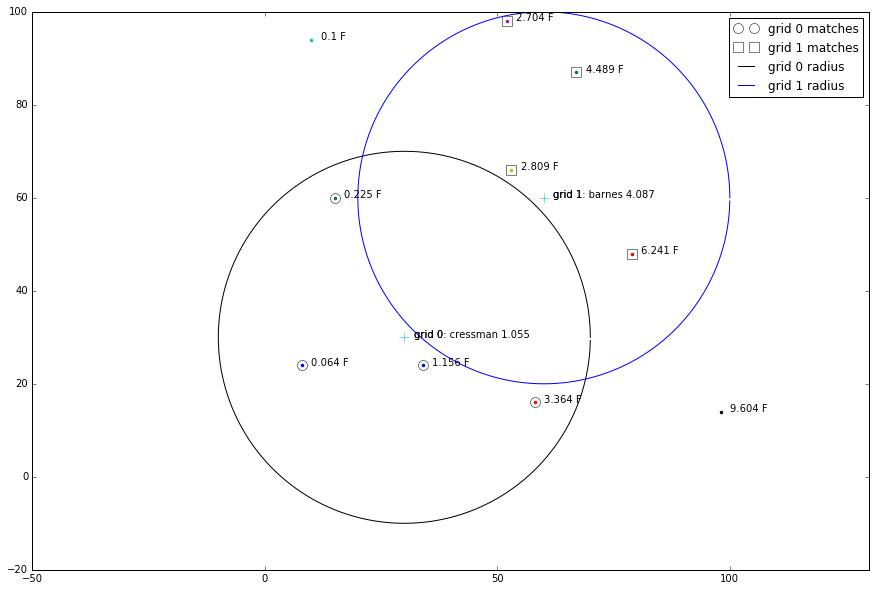

In [6]:
for i in range(len(z)):
    plt.plot(pts[i, 0], pts[i, 1], ".")
    plt.annotate(str(z[i]) + " F", xy=(pts[i, 0]+2, pts[i, 1]))

plt.plot(sim_gridx, sim_gridy, "+", markersize=10)

plt.annotate("grid 0", xy = (sim_gridx[0]+2, sim_gridy[0]))
plt.annotate("grid 1", xy = (sim_gridx[1]+2, sim_gridy[1]))

plt.plot(x1, y1, "ko", fillstyle='none', markersize=10, label="grid 0 matches")
plt.plot(x2, y2, "ks", fillstyle='none', markersize=10, label="grid 1 matches")

draw_circle(sim_gridx[0], sim_gridy[0], m="k-", r=radius, label="grid 0 radius")
draw_circle(sim_gridx[1], sim_gridy[1], m="b-", r=radius, label="grid 1 radius")

plt.annotate("grid 0: cressman " + ("%.3f" % cress_val),  xy = (sim_gridx[0]+2, sim_gridy[0]))
plt.annotate("grid 1: barnes "   + ("%.3f" % barnes_val), xy = (sim_gridx[1]+2, sim_gridy[1]))

plt.axes().set_aspect('equal', 'datalim')
plt.legend()

For each point, we will do a manual check of the interpolation values by doing a step by step and visual breakdown.

Plot the grid point, observations within radius of the grid point, their locations, and their distances from the grid point.

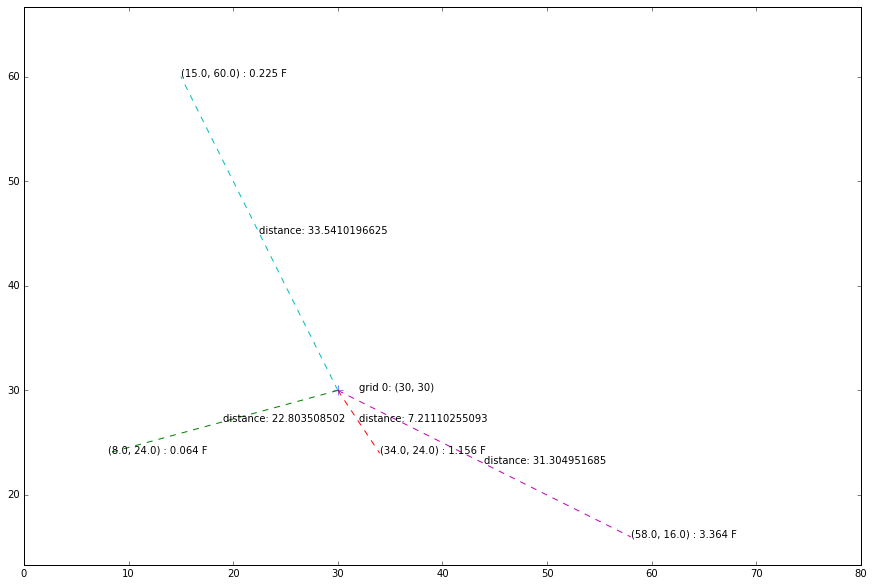

In [7]:
plt.annotate("grid 0: " + "(" + str(sim_gridx[0]) + ", " + str(sim_gridy[0]) + ")", xy = (sim_gridx[0]+2, sim_gridy[0]))
plt.plot(sim_gridx[0], sim_gridy[0], "+", markersize=10)

mx, my = obs_tree.data[indices[0]].T
mz = z[indices[0]]

for i in range(len(mz)):
    d = np.sqrt((sim_gridx[0]-mx[i])**2 + (my[i]-sim_gridy[0])**2)
    plt.plot([sim_gridx[0], mx[i]], [sim_gridy[0], my[i]], "--")
    
    xave = np.mean([sim_gridx[0], mx[i]])
    yave = np.mean([sim_gridy[0], my[i]])
    
    plt.annotate("distance: " + str(d), xy=(xave, yave))
    
    plt.annotate("(" + str(mx[i]) + ", " + str(my[i]) + ") : " + str(mz[i]) + " F", xy=(mx[i], my[i]))
    
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.axes().set_aspect('equal', 'datalim')

Step through the cressman calculations.

In [8]:
dists = np.array([22.803508502, 7.21110255093, 31.304951685, 33.5410196625])

values = np.array([0.064, 1.156, 3.364, 0.225])

cres_weights = (radius*radius - dists*dists) / (radius*radius + dists*dists)

total_weights = np.sum(cres_weights)

proportion = cres_weights / total_weights

value = values * proportion

val = cressman_point(cress_dist, cress_obs, radius)

print("Manual cressman value for grid 1: ", np.sum(value))

print("Metpy cressman value for grid 1:  ", val)

Manual cressman value for grid 1:  1.05499444404
Metpy cressman value for grid 1:   1.05499444404


Now repeat for grid 1, except use barnes interpolation.

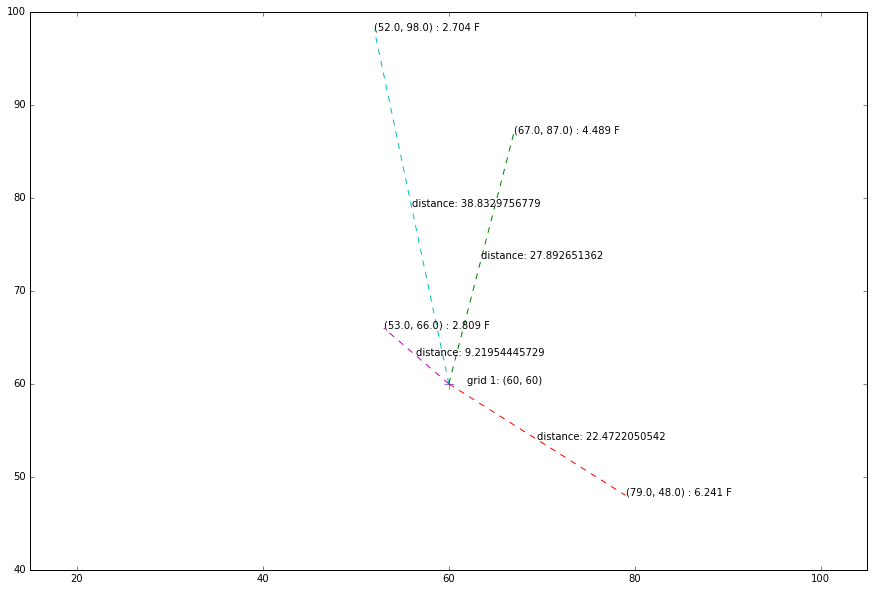

In [9]:
plt.annotate("grid 1: " + "(" + str(sim_gridx[1]) + ", " + str(sim_gridy[1]) + ")", xy = (sim_gridx[1]+2, sim_gridy[1]))
plt.plot(sim_gridx[1], sim_gridy[1], "+", markersize=10)

mx, my = obs_tree.data[indices[1]].T
mz = z[indices[1]]

for i in range(len(mz)):
    d = np.sqrt((sim_gridx[1]-mx[i])**2 + (my[i]-sim_gridy[1])**2)
    plt.plot([sim_gridx[1], mx[i]], [sim_gridy[1], my[i]], "--")
    
    xave = np.mean([sim_gridx[1], mx[i]])
    yave = np.mean([sim_gridy[1], my[i]])
    
    plt.annotate("distance: " + str(d), xy=(xave, yave))
    
    plt.annotate("(" + str(mx[i]) + ", " + str(my[i]) + ") : " + str(mz[i]) + " F", xy=(mx[i], my[i]))
    
plt.xlim(40, 80)
plt.ylim(40, 100)
plt.axes().set_aspect('equal', 'datalim')

Step through barnes calculations.

In [10]:
dists = np.array([9.21954445729, 22.4722050542, 27.892651362, 38.8329756779])

values = np.array([2.809, 6.241, 4.489, 2.704])

weights = np.exp(-dists**2 / kappa)

total_weights = np.sum(weights)
value = np.sum(values * (weights / total_weights))

val = barnes_point(barnes_dist, barnes_obs, kappa)

print("Manual barnes value: ", value)
print("Metpy barnes value:  ", val)

Manual barnes value:  4.08718241061
Metpy barnes value:   4.08718241061
